<a href="https://colab.research.google.com/github/newalchemy/personal_test/blob/main/PsychiatricDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diagnosing Psychiatric Illness with Deep Learning**

Deep learning has many uses in the medical field, and an emerging one is for use in diagnosing illness.  This is a project that was given to me for my deep learning course in graduate school.

The task is, given a set of patient fMRI data, build a classifier which determines whether or not a patient has a specifc psychiatric illness (the name of the illness is not given).

## **Dataset**

The data set is a set of 246 patient fMRI scans, encoded as real signals.  Each patient's fMRI is 94 separate signals, each recorded over the same 240 timesteps.  The first 144 patients had the illness, while the remaining 102 did not.  

## **Approach**

The overall approach is similar to how sentiment analysis is done in the NLP world; first, the signal data was encoded.  The fMRI data for each patient was sliced into 6 steps of 40, and then in each step the 94x94 signal correlation matrix was generated (that is, a matrix where each entry compares the correlation between signal i and j for that period).

Then, the relevant entries of the matrix were flattened.  This means that only the upper half of the matrix was used (since correlation matricies are symmetric), and the diagonal containing all 1s was ignored.  This resulted in 6 4371 dimensional vectors for each patient.  

Then, those vectors were each fed into a LSTM at 6 different steps, and the output was fed to a fully connected layer.  That fully connected layer was then connected down to 1 output neuron which was fed to a sigmoid, which was used as a classification decision.

5-Fold cross validation was used to prevent overfitting.

## **Measuring Performance**

I measured performance in the following ways:

1.  Average ending accuracy across all 5 test folds, in order to get a high level view of how the algorithm performs.

2.  For each fold, a plot showing test and training accuracy over epochs.  This shows performance, and can also help to detect overfitting, underfitting, learning rate issues, etc.

3.  For each fold, a plot showing the test and training loss over epochs.  This, used with the accuracy plot mentioned before, can help to show some of the issues mentioned previously.

4.  For each fold, a plot which shows the true positives/negatives and false positives/negatives over epochs for the test set.  This can help we debugging, just like the plots in 2.) and 3.) can.


## **Results and Analysis**

The average accuracy across 5 folds was about 70% - well below SotA, but above the naive classifier's accuracy of 58%.  

The biggest limitation is the size of the model.  Even with 16GB of GPU RAM, the model still needs to be configured so it can fit in the graphics card.  LSTMs and RNNs in general can be very memory intensive, but especially this one where each input vector has a dimension 4371.  Accurate sentiment analysis models which I've found online that follow this architecture use hidden layers which are of a much higher dimension than the input vectors.  For instance, an architecture I found which takes text and encodes each character across a 30-dimensional encoding (ie, input is one number), uses a hidden layer of size 150.  

Not only that, it may be better to take a sliding window of the signals and the correlation matrix at each sliding window.  However, that will add more model parameters which will take up more memory.

One way to get around that limitation could be to structure the model differently.  Instead of using the correlation matrix, use the raw signals.  This would lower the dimensionality of the overall input, but may compromise some of the effectiveness of it.

## **Sample Results**

Below are some plots from the metrics described above.  From the plot, several things are clear:     

1.  Far too many epochs are run:   This is only done to help show the fact that the model is at its best fit (ie, the test accuracy has a clear upper bound).

2.  The model is underfit, as shown by the loss and accuracy plots, but still produces value above that which a naive classifier would produce.  

3.  There are roughly as many false positives as there are false negatives, showing that there isn't an issue with the classifier isn't biased towards false positives or false negatives.

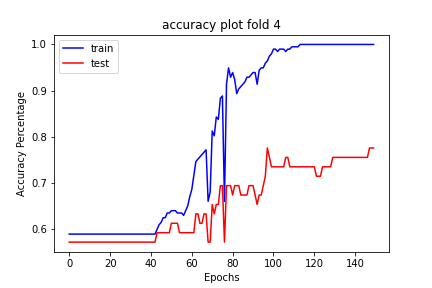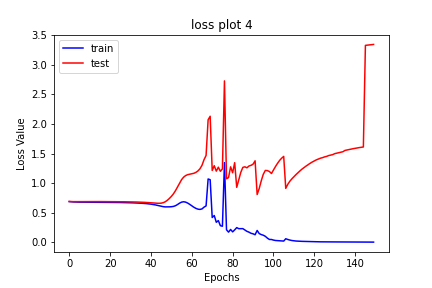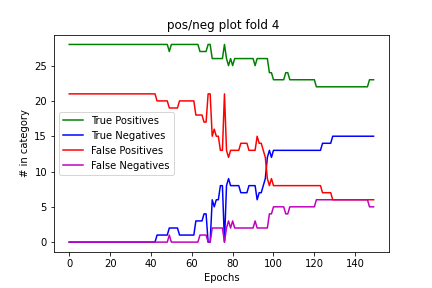


Preprocessing - build the correlation matrices for each sample and save them off.  Done entirely in RAM.

In [ ]:
import pickle
import pandas as pd
import torch
import numpy as np

from google.colab import drive

drive.mount('/content/drive');


file_name = '/content/drive/My Drive/BrainSamples/';

samples_list = [];

#Load the data into RAM.
for i in range(247):
    if (i == 0):
        continue;
        
    curFile = "train_sample{}.csv".format(i);
    full_file = file_name + curFile;
    
    df_cur = pd.read_csv(full_file);
    df_cur_T = df_cur.transpose();
    samples_list.append(df_cur_T);

FLATTENED_COR_LENGTH = int(94*95/2) - 94;
NUM_STOPS = 6;
NUM_SAMPLES = len(samples_list);


NUM_TIMEPOINTS = 240; # Defined by the problem, each signal is 240 time points.

STOP_SIZE = NUM_TIMEPOINTS/NUM_STOPS;


# Build the input matrix.  Each "stop" will have its own correlation matrix vector.
inp = torch.zeros(NUM_STOPS,NUM_SAMPLES,FLATTENED_COR_LENGTH);

for t in range(NUM_SAMPLES):    
    df_T = samples_list[t];
    
    # Slice the input signal into 5 as-equal-as-possible segments.
    for ra in range(NUM_STOPS):
        lwr = ra;
        upr = ra + 1;
    
        
        alls = df_T.iloc[:, STOP_SIZE*lwr:STOP_SIZE*upr];
        alls_t = alls.transpose();
        
        #Alls is a chunk of the signal across all 94 regions, within 50 time steps
        #Transposed because we want to find the correlation of the signal between the 94 
        # reginos of the brain.
        result = alls_t.corr();
        
        # Only use the upper triangular since the correlation matrix is symmetrical.
        # (Done for computational speed)
        result_ar = np.triu(result);
        
        ln = len(result_ar);
        
        ite = 0;
        
        # Preprocess correlation matrix for input into a RNN.
        # Turn matrix into a step in an ordered sequence.
        for i in range(ln):
            ro = result_ar[i];
            lr = len(ro);
            onlyZero = True;
            for k in range(lr):
                #Manually filter the entries which are 0 since the matrix is upper triangular 
                # (There's probably a quicker way of doing this.)
                if (ro[k] != 0):
                    # Skip the first 1.0 in each row, since it's on the diagonal of the correlation matrix.
                    if (onlyZero and (ro[k] == 1.0)):
                        onlyZero = False;
                    else:
                        inp[ra,t,ite] = ro[k];
                        ite = ite + 1;
        
del samples_list;
# Pickle the file off for future use.
with open(file_name + 'input_matrix_{}stops.pickle'.format(NUM_STOPS), 'wb') as handle:
    pickle.dump(inp, handle)

del inp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train, measure, and test the neural net architecture here.  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0
True
itr 0 epoch 0
itr 0 epoch 1
itr 0 epoch 2
itr 0 epoch 3
itr 0 epoch 4
itr 0 epoch 5
itr 0 epoch 6
itr 0 epoch 7
itr 0 epoch 8
itr 0 epoch 9
itr 0 epoch 10
itr 0 epoch 11
itr 0 epoch 12
itr 0 epoch 13
itr 0 epoch 14
itr 0 epoch 15
itr 0 epoch 16
itr 0 epoch 17
itr 0 epoch 18
itr 0 epoch 19
itr 0 epoch 20
itr 0 epoch 21
itr 0 epoch 22
itr 0 epoch 23
itr 0 epoch 24
itr 0 epoch 25
itr 0 epoch 26
itr 0 epoch 27
itr 0 epoch 28
itr 0 epoch 29
itr 0 epoch 30
itr 0 epoch 31
itr 0 epoch 32
itr 0 epoch 33
itr 0 epoch 34
itr 0 epoch 35
itr 0 epoch 36
itr 0 epoch 37
itr 0 epoch 38
itr 0 epoch 39
itr 0 epoch 40
itr 0 epoch 41
itr 0 epoch 42
itr 0 epoch 43
itr 0 epoch 44
itr 0 epoch 45
itr 0 epoch 46
itr 0 epoch 47
itr 0 epoch 48
itr 0 epoch 49
itr 0 epoch 50
itr 0 epoch 51
itr 0 epoch 52
itr 0 epoch 53
itr 0 epoch 54
itr 0 epoch 55
itr 0 epoch 56
itr 0 epoch 57

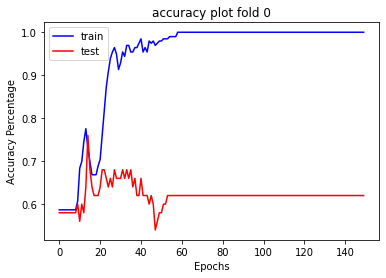

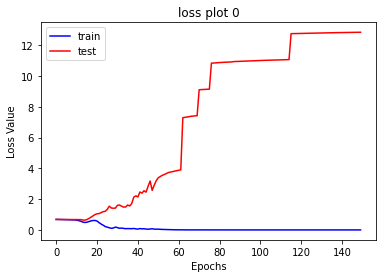

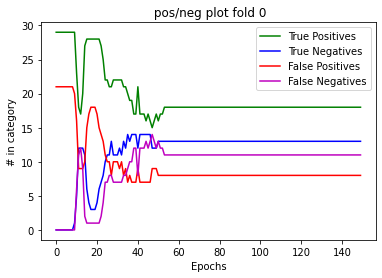

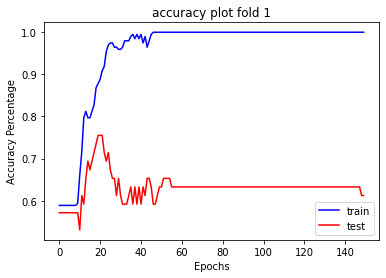

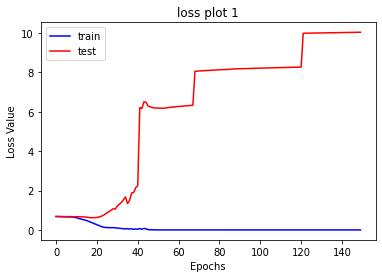

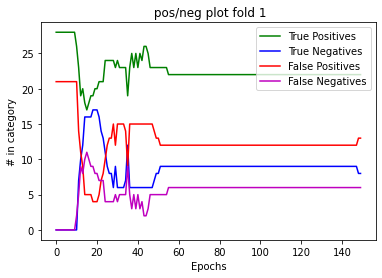

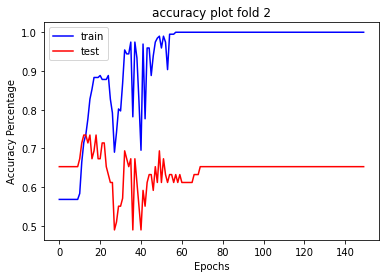

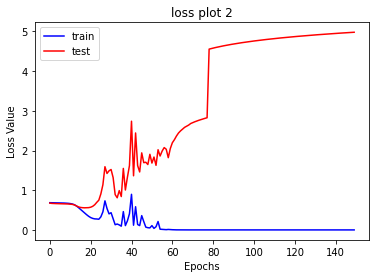

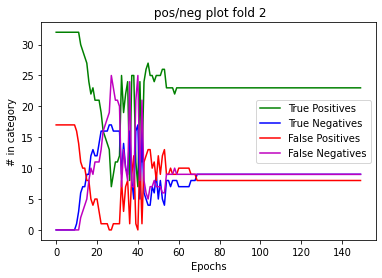

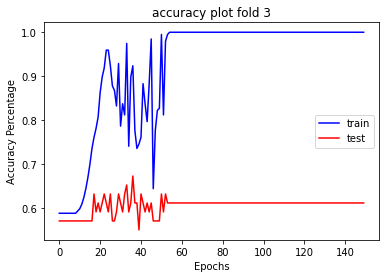

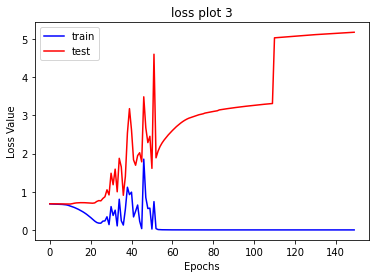

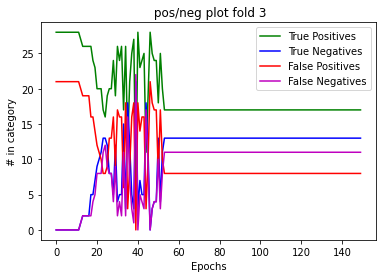

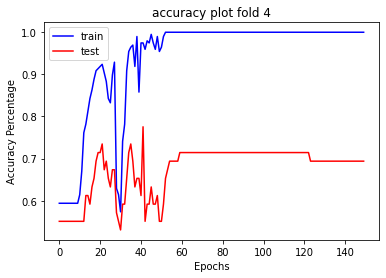

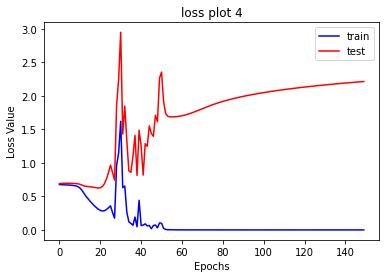

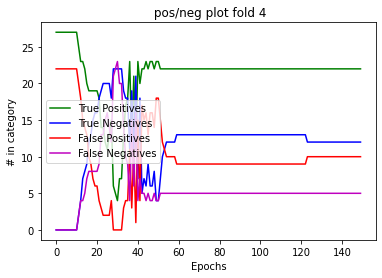

In [ ]:
import pandas as pd

import torch
import torch.nn as nn
from random import sample
import math
from sklearn.model_selection import KFold
import copy
import random
import numpy as np
import pickle
import torch.nn as nn

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os

from google.colab import drive

import math

drive.mount('/content/drive');

device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device0)

file_name = '/content/drive/My Drive/BrainSamples/';

file_loc = '/content/drive/My Drive/BrainScanOut/';

drive = '/content/drive/';

FLATTENED_COR_LENGTH = int(94*95/2) - 94;

### PARAMETERS and HYPERPARAMETERS ###
learning_rate = 10**-2;
num_epochs = 150;
weightdecay = 0;

num_folds = 5;
num_hidden_layers = 2;
batch_size = 1;

OUTPUT_SIZE = 2500;
HIDDEN_SIZE = 2*FLATTENED_COR_LENGTH;
NUM_STOPS = 6;

### PARAMETERS and HYPERPARAMETERS end ###

with open(file_name + 'input_matrix_{}stops.pickle'.format(NUM_STOPS), 'rb') as handle:
    inp = pickle.load(handle)


# Functions for plotting.
def make_accuracy_plot(epochs, train_accuracies, test_accuracies, fold_num, file_path):
    if not ((len(epochs) == len(train_accuracies)) and (len(epochs) == len(test_accuracies))):
        print('cant make accuracy plot, lengths of all three lists are not equal {} {} {}'.format(len(epochs), len(train_accuracies), len(test_accuracies)));
    
    plot_title = 'accuracy plot fold {}'.format(fold_num);
    file_title = 'accuracyPlot{}'.format(fold_num);
    file_loc = '{}{}'.format(file_path, file_title);
    
    plt.figure();
    plt.title(plot_title);
    plt.ylabel('Accuracy Percentage');
    plt.xlabel('Epochs');
    plt.plot(epochs, train_accuracies, 'b', label='train');
    plt.plot(epochs, test_accuracies, 'r', label='test');
    plt.legend();
    plt.savefig(file_loc);

def make_losses_plot(epochs, train_losses, test_losses, fold_num, file_path):
    if not ((len(epochs) == len(train_losses)) and (len(epochs) == len(test_losses))):
        print('cant make accuracy plot, lengths of all three lists are not equal {} {} {}'.format(len(epochs), len(train_losses), len(test_losses)));
    
    plot_title = 'loss plot {}'.format(fold_num);
    file_title = 'lossPlot{}'.format(fold_num);
    file_loc = '{}{}'.format(file_path, file_title);
    
    plt.figure();
    plt.title(plot_title);
    plt.ylabel('Loss Value');
    plt.xlabel('Epochs');
    plt.plot(epochs, train_losses, 'b', label='train');
    plt.plot(epochs, test_losses, 'r', label='test');
    plt.legend();
    plt.savefig(file_loc);
    
def make_truefalse_plots(epochs, all_true_pos, all_true_neg, all_false_pos, all_false_neg, fold_num, file_path):
    
    plot_title = ' pos/neg plot fold {}'.format(fold_num);
    file_title = 'posNegPlot{}'.format(fold_num);
    file_loc = '{}{}'.format(file_path, file_title);
    
    plt.figure();
    plt.title(plot_title);
    plt.ylabel('# in category');
    plt.xlabel('Epochs');
    plt.plot(epochs, all_true_pos, 'g', label='True Positives');
    plt.plot(epochs, all_true_neg, 'b', label='True Negatives');    
    plt.plot(epochs, all_false_pos, 'r', label='False Positives');
    plt.plot(epochs, all_false_neg, 'm', label='False Negatives');

    plt.legend();
    plt.savefig(file_loc);

    
inp = inp.to(device0);

# Size of training set as well as number of positives and negatives are 
# hard coded since they were set that way in the assignment.
options = list(range(1, 247));

pos = [1 for i in range(144)];
neg = [0 for i in range(102)];

labels = torch.Tensor(pos + neg);
labels = labels.to(device0);

kf = KFold(num_folds, shuffle=True);
splits = kf.split(options);

# The actual neural network.  
class MRIClassifier(nn.Module):
    def __init__(self, inp_size, hid_size, num_hidden_layers, proj_size):
        super().__init__()
        
        self.hidden_size = hid_size;
        self.num_hidden_layers = num_hidden_layers;
        self.proj_size = proj_size;
        #self.rnnlayer = nn.LSTM(input_size=STATE_SIZE,hidden_size=HIDDEN_SIZE, num_layers=num_hidden_layers, proj_size=OUTPUT_SIZE);
        self.rnnlayer = nn.LSTM(input_size=inp_size,hidden_size=self.hidden_size, num_layers=self.num_hidden_layers, proj_size=self.proj_size);


        self.attention_vec = torch.FloatTensor([0,0,0,0,0,0,0,1]);
        self.attention_vec = self.attention_vec.to(device0);


        self.hidden1 = nn.Linear(4096, 1024, bias=True)

        # Inputs to hidden layer linear transformation
        # Output layer, 10 units - one for each digit
        self.act = nn.Tanh();

        self.output = nn.Linear(OUTPUT_SIZE, 1, bias=True, device=device0)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, h0, c0):
        # Pass the input tensor through each of our operations    
        xs, hi = self.rnnlayer(x, (h0, c0));
            
        x = torch.matmul(xs.transpose(2,0), self.attention_vec);
        x = x.transpose(1,0)

        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

    def init_hidden(self, batch_size):
      # Initialize the hidden and cell states for the LSTM.
        new_hidden = torch.zeros(self.num_hidden_layers, batch_size, self.proj_size);
        new_cell = torch.zeros(self.num_hidden_layers, batch_size, self.hidden_size);
        return new_hidden, new_cell;

itr = 0;
accuracies = [];


# The splits are designed in such a way that every sample will get a turn in one of the 5 test sets.  
for cur_train, cur_test in splits:

    # Initialize the model and optimizer.  Make sure the model is on the GPU.
    model = MRIClassifier(FLATTENED_COR_LENGTH, HIDDEN_SIZE, num_hidden_layers, OUTPUT_SIZE);
    model = model.to(device0);
    criterion = nn.BCELoss();

    optimizer = torch.optim.SGD(
            model.parameters(), lr=learning_rate, weight_decay=weightdecay)
        
    random.shuffle(cur_train);


    num_batches = math.ceil(len(cur_train)/batch_size);
    
    # These empty lists are for plotting
    all_losses_train = [];
    all_accuracies_train = [];
    
    all_losses_test = [];
    all_accuracies_test = [];
    
    all_true_pos = [];
    all_true_neg = [];
    all_false_pos = [];
    all_false_neg = [];
    
    times = [];
    
    for epoch in range(num_epochs):
        h0, c0 = model.init_hidden(batch_size);
        h0 = h0.to(device0);
        c0 = c0.to(device0);

        times.append(epoch);
        for b in range(num_batches):
            
            b_begin = b*batch_size;
            b_end = min((b+1)*batch_size, len(cur_train));
            
            inxes = cur_train[b_begin:b_end];
            myStates = inp[:,inxes,:];
            myLabels = labels[inxes];
            num_in_batch = len(inxes)

            # -- Forward Pass -- 
            if (num_in_batch == batch_size):
              output = model(myStates, h0, c0);
            else:
              batch_inxes = [i for i in range(num_in_batch)]
              output = model(myStates, h0[:, batch_inxes, :], c0[:, batch_inxes, :])
            
            if not len(output) == 1:
                loss = criterion(output.squeeze(),myLabels);
            else:
                loss = criterion(output.squeeze(), myLabels.squeeze());
            # -- Backward {ass --
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('itr {} epoch {}'.format(itr, epoch));


        # Find total training loss and test loss for plotting
        all_train_inp = inp[:,cur_train,:];
        all_labels = labels[cur_train];

        h0, c0 = model.init_hidden(len(all_labels));
        h0 = h0.to(device0);
        c0 = c0.to(device0);

        output = model(all_train_inp, h0, c0);
        loss = criterion(output.squeeze(),all_labels);

        all_losses_train.append(loss.item());
            
        pred_pos = output.squeeze() >= 0.5;
            
        num_right = int(sum(torch.eq(pred_pos, all_labels)));
        num_tot = len(all_labels);
        accur = num_right / num_tot;
        all_accuracies_train.append(accur);
            
        test_states = inp[:,cur_test,:];
        test_labels = labels[cur_test];

        h0, c0 = model.init_hidden(len(test_labels));
        h0 = h0.to(device0);
        c0 = c0.to(device0);
            
        out_test = model(test_states, h0, c0);
        
        # Gather True/False Positives and Negatives.  Measure overall accuracy for both testing and training sets.
        pred_pos_test = out_test.squeeze() >= 0.5;
        pred_neg_test = out_test.squeeze() < 0.5;
            
        truth_pos_test = test_labels >= 0.5;
        truth_neg_test = test_labels < 0.5;
            
        num_right_test = int(sum(torch.eq(pred_pos_test, test_labels)));
        num_tot_test = len(test_labels);
        accur_test = num_right_test / num_tot_test;
        all_accuracies_test.append(accur_test);
            
        true_pos = int(sum(torch.logical_and(pred_pos_test, truth_pos_test)));
        true_neg = int(sum(torch.logical_and(pred_neg_test, truth_neg_test)));
            
        false_pos = int(sum(torch.logical_and(pred_pos_test, truth_neg_test)));
        false_neg = int(sum(torch.logical_and(pred_neg_test, truth_pos_test)));
            
        all_true_pos.append(true_pos);
        all_true_neg.append(true_neg);
        all_false_pos.append(false_pos);
        all_false_neg.append(false_neg);

            
        loss_test = criterion(out_test.squeeze(), test_labels);
        all_losses_test.append(loss_test.item());
        optimizer.zero_grad()

        #scheduler.step();

    
    # Make the measurement plots
    make_accuracy_plot(times, all_accuracies_train, all_accuracies_test, itr, file_loc);
    make_losses_plot(times, all_losses_train, all_losses_test, itr, file_loc);

    make_truefalse_plots(times, all_true_pos, all_true_neg, all_false_pos, all_false_neg, itr, file_loc);            

    name = '/content/drive/My Drive/BrainScanOut/trainedNetwork{}.pth'.format(itr);
        
    torch.save(model.state_dict(), name);
    
            
    itr = itr + 1;
    accuracies.append(all_accuracies_test[-1]);

print('accuracies: ', accuracies);
print('average: ', sum(accuracies)/len(accuracies))
bp = 'bp';

print('***************************************************************************');
